## Геометрическое распределение

---

In [49]:
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import utils, geom_utils 
from matplotlib import pyplot as plt


def reload_files():
    importlib.reload(geom_utils)
    importlib.reload(utils)

In [2]:
DATASETS = {
    0: 'acl-imdb'
}

LABELS = {
    'positive': 1,
    'negative': -1
}

In [47]:
reload_files()

### Загружаем экспериментальные данные

---

In [48]:
data = utils.load_data(DATASETS[0])

data.head()

,text,label
0,Don't bother trying to watch this terrible min...,-1
1,"Space Camp, which had the unfortunate luck to ...",-1
2,"Well, I suppose the good news concerning Willi...",-1
3,"After leaving TV's popular ""The Andy Griffith ...",-1
4,"I knew I was going to see a low budget movie, ...",-1


### Токенизируем данные

---

In [4]:
data['tokens'] = [[token for token in utils.word_tokenize(text, stop_words=False)] for text in data['text']]

data.head()

,text,label,tokens
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg..."


In [5]:
lengths = data['tokens'].apply(len)

q1, q3 = np.quantile(lengths, [0.25, 0.75])
iqr = q3 - q1

data = data[~((lengths < (q1-1.5*iqr)) | (lengths > (q3+1.5*iqr)))]

### Находим части речи

---

In [6]:
from nltk import pos_tag_sents


data['pos_tokens'] = pos_tag_sents(data['tokens'], tagset='universal')
data['pos_tokens'] = utils.pos_filter(data['pos_tokens'])

data.head()

,text,label,tokens,pos_tokens
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter...","[(do, VERB), (not, ADV), (bother, VERB), (tryi..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu...","[(space, NOUN), (camp, NOUN), (which, DET), (h..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning...","[(well, ADV), (i, NOUN), (suppose, VERB), (the..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr...","[(after, ADP), (leaving, VERB), (tv, NOUN), (s..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg...","[(i, NOUN), (knew, VERB), (i, NOUN), (was, VER..."


### Формируем $n$-граммы

---

In [7]:
n = 2

data['ngrams'] = utils.ngrams_sents(data['pos_tokens'], n=n)

data.head()

,text,label,tokens,pos_tokens,ngrams
0,Don't bother trying to watch this terrible min...,-1,"[do, not, bother, trying, to, watch, this, ter...","[(do, VERB), (not, ADV), (bother, VERB), (tryi...","[((do, VERB), (not, ADV)), ((not, ADV), (bothe..."
1,"Space Camp, which had the unfortunate luck to ...",-1,"[space, camp, which, had, the, unfortunate, lu...","[(space, NOUN), (camp, NOUN), (which, DET), (h...","[((space, NOUN), (camp, NOUN)), ((camp, NOUN),..."
2,"Well, I suppose the good news concerning Willi...",-1,"[well, i, suppose, the, good, news, concerning...","[(well, ADV), (i, NOUN), (suppose, VERB), (the...","[((well, ADV), (i, NOUN)), ((i, NOUN), (suppos..."
3,"After leaving TV's popular ""The Andy Griffith ...",-1,"[after, leaving, tv, s, popular, the, andy, gr...","[(after, ADP), (leaving, VERB), (tv, NOUN), (s...","[((after, ADP), (leaving, VERB)), ((leaving, V..."
4,"I knew I was going to see a low budget movie, ...",-1,"[i, knew, i, was, going, to, see, a, low, budg...","[(i, NOUN), (knew, VERB), (i, NOUN), (was, VER...","[((i, NOUN), (knew, VERB)), ((knew, VERB), (i,..."


### Оцениваем параметры распределений и проверяем гипотезы согласия

---

In [8]:
def geom(data):
    populations = dict()
    geom_populations = dict()
    for i, (label, label_index) in enumerate(LABELS.items()):
        label_data = data[data['label'] == label_index]
        populations[label] = {k: v for k, v in geom_utils.populate(label_data['ngrams']).items() if len(v) > 30}
        geom_populations[label] = geom_utils.geom_filter(populations[label])
    return populations, geom_populations

In [12]:
populations, geom_populations = geom(data)

### Находим нейтральные и полярные $n$-граммы

---

In [13]:
# Нейтральные n-граммы

neutral_keys = geom_populations['positive'].keys() & geom_populations['negative'].keys()

neutral_ngrams = {label: {key: label_population[key] for key in neutral_keys} for label, label_population in geom_populations.items()}

print(f'[neutral ngrams] Total: {len(neutral_keys)}')

[neutral ngrams] Total: 1729


In [14]:
# Позитивные n-граммы

positive_keys = geom_populations['positive'].keys() - geom_populations['negative'].keys()

positive_ngrams = {key: geom_populations['positive'][key] for key in positive_keys}

print(f'[positive ngrams] Total: {len(positive_keys)}')

[positive ngrams] Total: 1878


In [15]:
# Негативные n-граммы

negative_keys = geom_populations['negative'].keys() - geom_populations['positive'].keys()

negative_ngrams = {key: geom_populations['negative'][key] for key in negative_keys}

print(f'[negative ngrams] Total: {len(negative_keys)}')

[negative ngrams] Total: 1925


In [16]:
polar_ngrams = {'positive': positive_ngrams, 'negative': negative_ngrams}

print(f'[polar ngrams] Total: {len(positive_keys) + len(negative_keys)}')

[polar ngrams] Total: 3803


---

In [17]:
def to_dataframe(ngrams):
    df = pd.DataFrame(ngrams)
    words, pos_tags = zip(*[zip(*ngram) for ngram in df.index])
    df.index = words
    df.insert(0, 'part_of_speech', pos_tags, True)
    return df

### Рассматриваем распределения параметров нейтральных $n$-грамм

---

In [18]:
neutral_df = to_dataframe(neutral_ngrams)

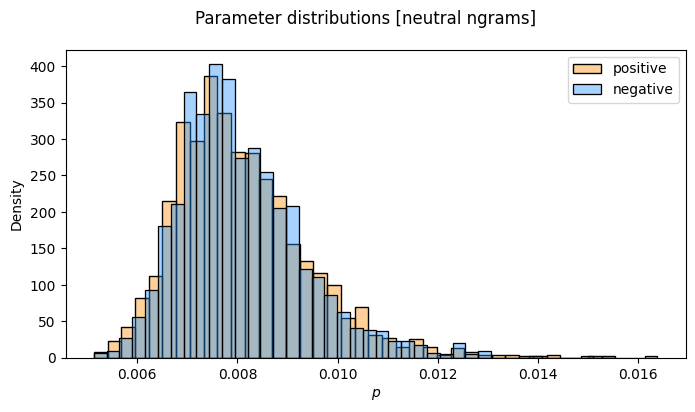

In [19]:
geom_utils.hist(neutral_df, title='Parameter distributions [neutral ngrams]')

In [20]:
from scipy.stats import ttest_ind, mannwhitneyu

print(f"mannwhitneyu (pvalue)\t: p-value={mannwhitneyu(neutral_df['positive'], neutral_df['negative']).pvalue}")
print(f"ttest (pvalue)\t\t: p-value={ttest_ind(neutral_df['positive'], neutral_df['negative']).pvalue}")

mannwhitneyu (pvalue)	: p-value=0.8458781595398202
ttest (pvalue)		: p-value=0.7959533787907422


### Рассматриваем распределения параметров нейтральных $n$-грамм отдельных частей речи

---

In [21]:
from itertools import permutations

neutral_counts = neutral_df['part_of_speech'].value_counts()
neutral_keys = neutral_counts.index[(neutral_counts > 10) & neutral_counts.index.isin(set(permutations(['ADJ', 'ADV', 'NOUN', 'VERB'], n)))]

list(enumerate(zip(neutral_keys, neutral_counts)))

[(0, (('NOUN', 'VERB'), 157)),
 (1, (('VERB', 'ADV'), 127)),
 (2, (('ADJ', 'NOUN'), 83)),
 (3, (('ADV', 'VERB'), 73)),
 (4, (('NOUN', 'ADV'), 69)),
 (5, (('VERB', 'NOUN'), 64)),
 (6, (('VERB', 'ADJ'), 57)),
 (7, (('ADV', 'NOUN'), 53))]

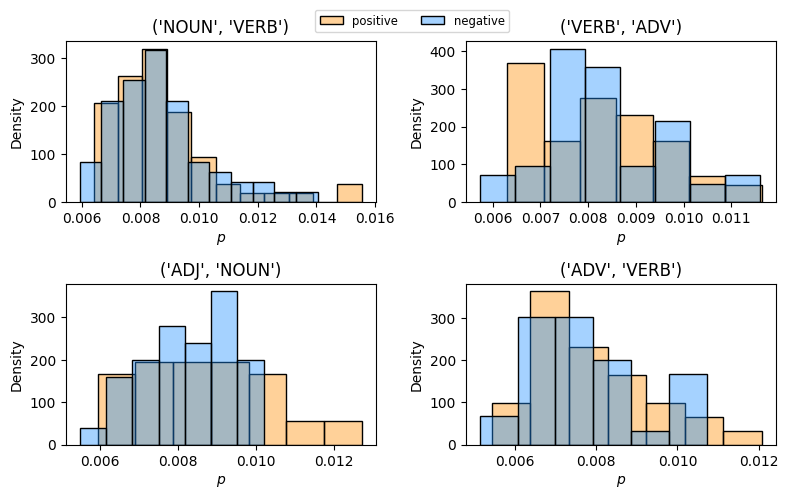

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

i = 0
for row in ax:
    for column in row:
        df = neutral_df[neutral_df['part_of_speech'] == neutral_keys[i]]
        
        sns.histplot(df['positive'], stat='density', bins='auto', color='darkorange', alpha=0.4, ax=column, label='positive' if i == 0 else None)
        sns.histplot(df['negative'], stat='density', bins='auto', color='dodgerblue', alpha=0.4, ax=column, label='negative' if i == 0 else None)
        
        column.set_title(neutral_keys[i])
        column.set_xlabel(r'$p$')
        
        i += 1
        
fig.legend(bbox_to_anchor=(0, 0, 0.65, 1), framealpha=0.8, fontsize='small', ncol=2)
fig.tight_layout()
plt.show()

In [35]:
for i in range(4):
    df = neutral_df[neutral_df['part_of_speech'] == neutral_keys[i]]
    print(f'{neutral_keys[i]}: ')
    print(f"mannwhitneyu\t: p-value={mannwhitneyu(df['positive'], df['negative']).pvalue }")
    print(f"ttest\t\t: p-value={ttest_ind(df['positive'], df['negative']).pvalue}\n")

('NOUN', 'VERB'): 
mannwhitneyu	: p-value=0.8246256834261783
ttest		: p-value=0.8784585734507598

('VERB', 'ADV'): 
mannwhitneyu	: p-value=0.5864076992826202
ttest		: p-value=0.6317730511934927

('ADJ', 'NOUN'): 
mannwhitneyu	: p-value=0.2343652276932594
ttest		: p-value=0.14628804684631827

('ADV', 'VERB'): 
mannwhitneyu	: p-value=0.9732217321086247
ttest		: p-value=0.8580208435433114



---

In [24]:
KEY = 2

df = neutral_df[neutral_df['part_of_speech'] == neutral_keys[KEY]]

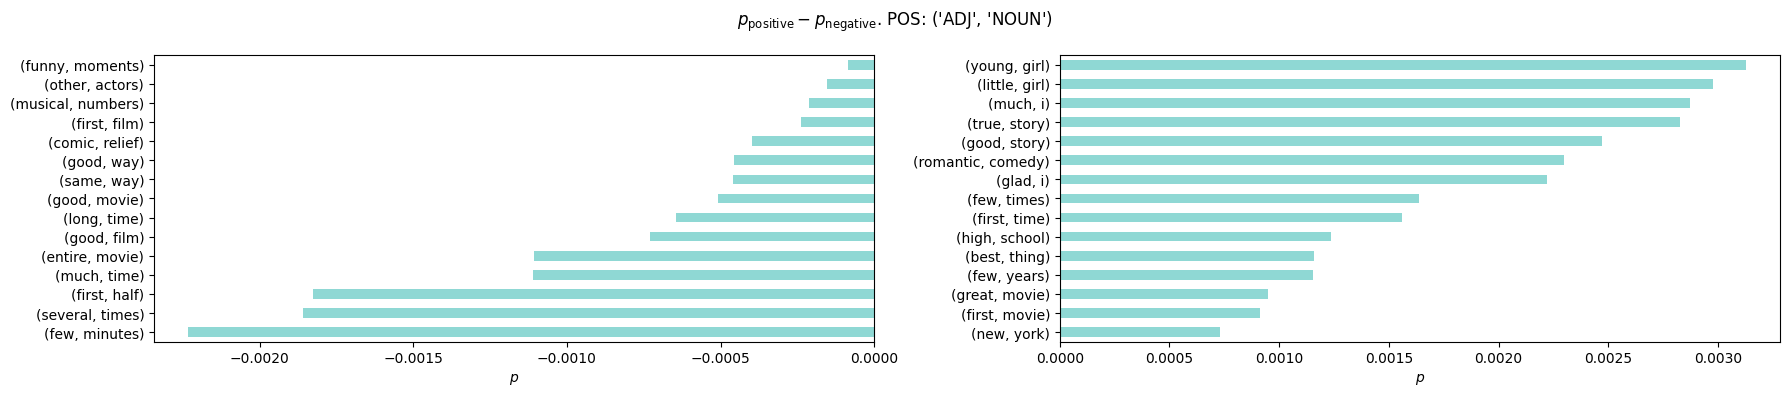

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4), dpi=100)

(df['positive']-df['negative']).sort_values().head(15).plot.barh(color='lightseagreen', alpha=0.5, ax=ax1)
(df['positive']-df['negative']).sort_values().tail(15).plot.barh(color='lightseagreen', alpha=0.5, ax=ax2)

ax1.set_xlabel(r'$p$')
ax2.set_xlabel(r'$p$')

fig.suptitle(r'$p_{\mathrm{positive}}-p_{\mathrm{negative}}$.' + f' POS: {neutral_keys[KEY]}')

fig.tight_layout()

### Рассматриваем распределения параметров полярных $n$-грамм

---

In [26]:
polar_df = to_dataframe(polar_ngrams)

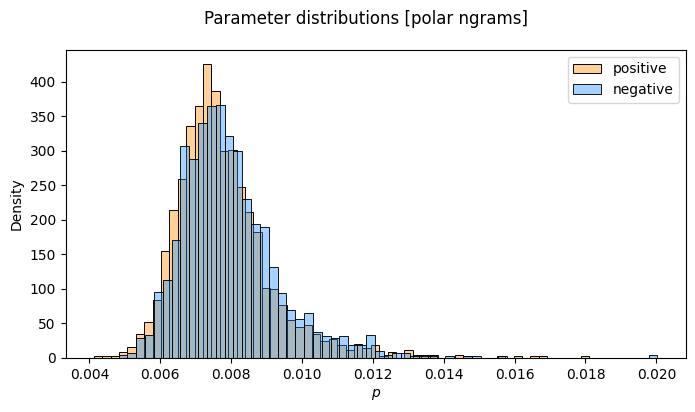

In [27]:
geom_utils.hist(polar_df, title='Parameter distributions [polar ngrams]')

In [28]:
print(f"mannwhitneyu (pvalue)\t: p-value={mannwhitneyu(polar_df['positive'], polar_df['negative'], nan_policy='omit').pvalue}")
print(f"ttest (pvalue)\t\t: p-value={ttest_ind(polar_df['positive'], polar_df['negative'], nan_policy='omit').pvalue}")

mannwhitneyu (pvalue)	: p-value=1.052228790030031e-06
ttest (pvalue)		: p-value=5.0707355841555855e-05


### Рассматриваем распределения параметров полярных $n$-грамм отдельных частей речи

---

In [29]:
polar_counts = polar_df['part_of_speech'].value_counts()
polar_keys = polar_counts.index[(polar_counts > 20) & polar_counts.index.isin(set(permutations(['ADJ', 'ADV', 'NOUN', 'VERB'], n)))]

list(enumerate(zip(polar_keys, polar_counts)))

[(0, (('ADJ', 'NOUN'), 339)),
 (1, (('NOUN', 'VERB'), 224)),
 (2, (('VERB', 'ADV'), 169)),
 (3, (('ADV', 'VERB'), 165)),
 (4, (('VERB', 'ADJ'), 151)),
 (5, (('ADV', 'ADJ'), 131)),
 (6, (('VERB', 'NOUN'), 123)),
 (7, (('NOUN', 'ADV'), 111)),
 (8, (('ADV', 'NOUN'), 107))]

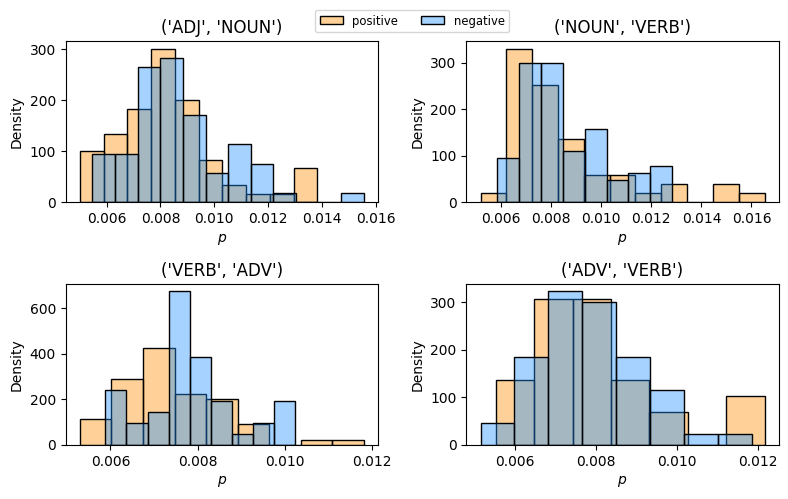

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

i = 0
for row in ax:
    for column in row:
        df = polar_df[polar_df['part_of_speech'] == polar_keys[i]]
        
        sns.histplot(df['positive'], stat='density', bins='auto', color='darkorange', alpha=0.4, ax=column, label='positive' if i == 0 else None)
        sns.histplot(df['negative'], stat='density', bins='auto', color='dodgerblue', alpha=0.4, ax=column, label='negative' if i == 0 else None)
        
        column.set_title(polar_keys[i])
        column.set_xlabel(r'$p$')
        
        i += 1
        
fig.legend(bbox_to_anchor=(0, 0, 0.65, 1), framealpha=0.8, fontsize='small', ncol=2)
fig.tight_layout()
plt.show()

In [34]:
for i in range(4):
    df = polar_df[polar_df['part_of_speech'] == polar_keys[i]]
    print(f'{polar_keys[i]}: ')
    print(f"mannwhitneyu\t: p-value={mannwhitneyu(df['positive'], df['negative'], nan_policy='omit').pvalue }")
    print(f"ttest\t\t: p-value={ttest_ind(df['positive'], df['negative'], nan_policy='omit').pvalue}\n")

('ADJ', 'NOUN'): 
mannwhitneyu	: p-value=0.2523185573351808
ttest		: p-value=0.3027847273751288

('NOUN', 'VERB'): 
mannwhitneyu	: p-value=0.39126300762461297
ttest		: p-value=0.9988892763669659

('VERB', 'ADV'): 
mannwhitneyu	: p-value=0.031780642592204734
ttest		: p-value=0.08909154742973815

('ADV', 'VERB'): 
mannwhitneyu	: p-value=0.6013430570187792
ttest		: p-value=0.8540330684760158



### Полярные $n$-граммы с наибольшими значениями параметров

---

In [32]:
KEY = 4    # выбор части речи

df = polar_df[polar_df['part_of_speech'] == polar_keys[KEY]]

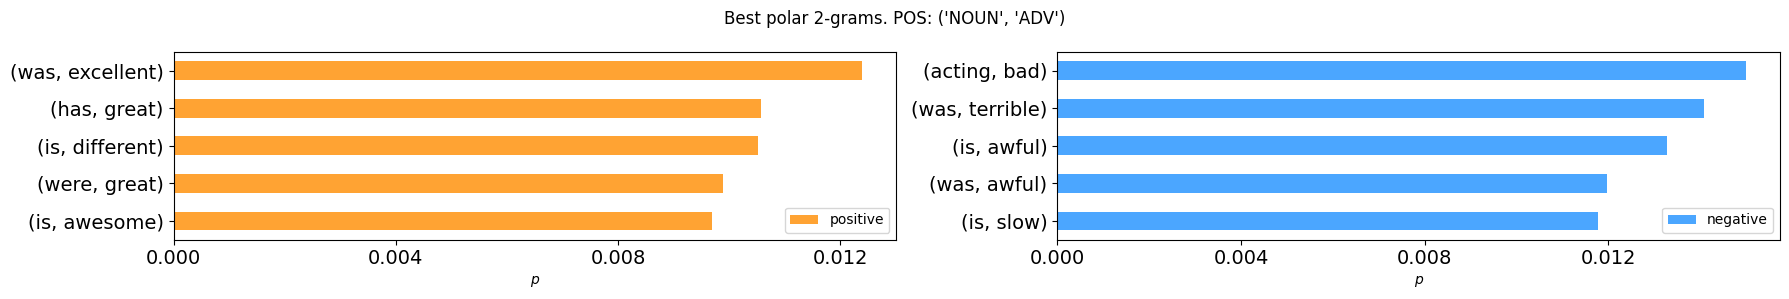

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 3), dpi=100)

df.sort_values(by='positive', na_position='first').tail(5).plot.barh(y='positive', color='darkorange', alpha=0.8, ax=ax1, label='positive', fontsize=14)

df.sort_values(by='negative', na_position='first').tail(5).plot.barh(y='negative', color='dodgerblue', alpha=0.8, ax=ax2, label='negative', fontsize=14)

ax1.set_xlabel(r'$p$')
ax2.set_xlabel(r'$p$')
ax1.set_xticks([0, 0.004, 0.008, 0.012])
ax2.set_xticks([0, 0.004, 0.008, 0.012])

plt.legend(loc='lower right')

fig.suptitle(f'Best polar {n}-grams. POS: {neutral_keys[KEY]}')

fig.tight_layout()